In [2]:
import time
import cv2 as cv
import mediapipe as mp
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from models.hand_gesture import HandGesture
from models.hand_gesture import normalized_landmarks, landmark_bbox
from models.character_recognize import CharacterRecognize

In [3]:
PATH = 'data/videos/20240402084102.mp4'
GESTURE_MODEL_PATH = 'models/hand_gesture_model.pth'
CHARACTER_MODEL_PATH = 'models/character_recognizer_model.pth'

In [4]:
def position_scaler(points):  # scales to 28*28 pixel
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]

    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)

    scaled_points = []
    for x, y in points:  # 4 to 25
        scaled_x = 4 + ((x - min_x) * (22 - 1)) // (max_x - min_x) # needs debug
        scaled_y = 4 + ((y - min_y) * (22 - 1)) // (max_y - min_y)
        scaled_points.append((scaled_x, scaled_y))
    return scaled_points


points = [(14, 15), (70, 70), (48, 12)]
print(position_scaler(points))

[(4, 5), (25, 25), (16, 4)]


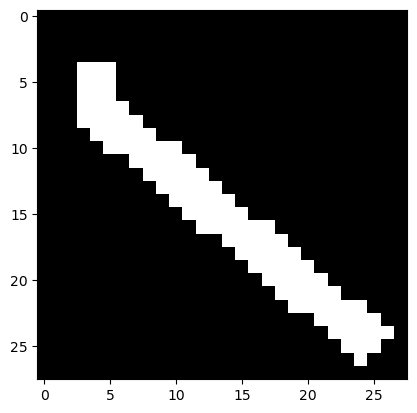

In [5]:
def position_to_image(positions):  # positions to 28*28 image
    positions = position_scaler(positions)
    image_size = (28, 28)
    image = Image.new("L", image_size, color="black")
    draw = ImageDraw.Draw(image)
    for i in range(1, len(positions)):
        x1, y1 = positions[i - 1]
        x2, y2 = positions[i]
        draw.line([(x1, y1), (x2, y2)], width=3, fill="white")
    return image


image = position_to_image([(1, 3), (5, 20), (140, 120)])
plt.imshow(image, cmap='grey')

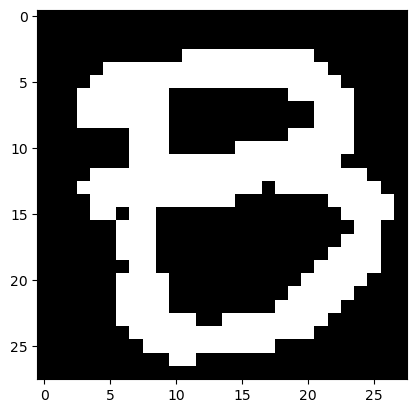

B


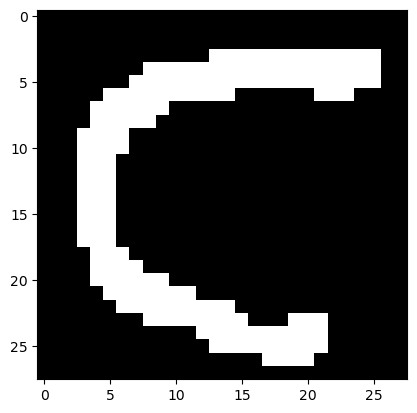

C


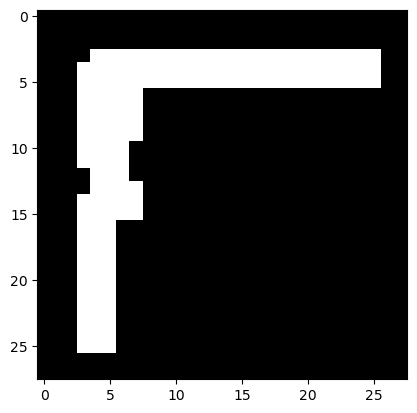

T


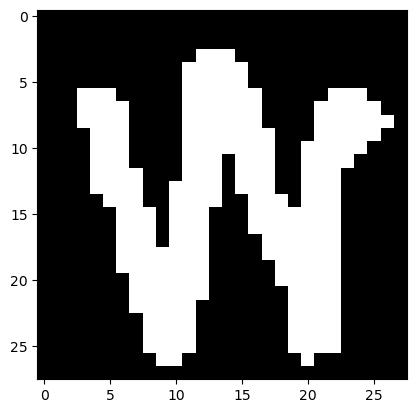

W


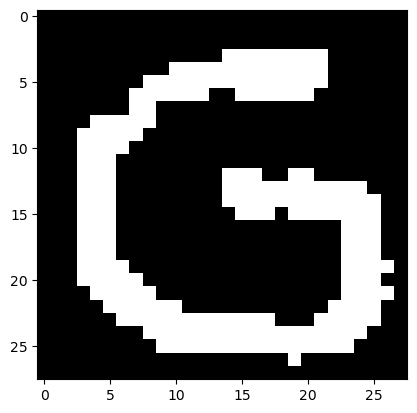

G


In [9]:
PATH = 'data/videos/test.mp4'
video = cv.VideoCapture(PATH)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

Trail = []
gesture_recognizer = HandGesture(GESTURE_MODEL_PATH)
character_recognizer = CharacterRecognize(CHARACTER_MODEL_PATH)

clenched_fist_timer = None
open_palm_timer = None
text = ""
while video.isOpened():
    # speed 3x times faster 
    ret, frame = video.read()
    ret, frame = video.read()
    ret, frame = video.read()
    if ret:
        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        H, W, _ = frame.shape
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                position = normalized_landmarks(hand_landmarks, H, W)
                pred, confidence = gesture_recognizer.predict(position)
                pred = pred.replace('_', ' ')

                if pred == 'index finger up' and confidence > 0.98:
                    gesture = 'Index finger up'
                elif pred == 'clenched fist' and confidence > 0.97:
                    gesture = 'Clenched fist'
                elif pred == 'open palm' and confidence > 0.98:
                    gesture = 'Open palm'
                else:
                    gesture = 'No gesture'

                if gesture == 'Index finger up':
                    index_finger = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
                    cx, cy = int(index_finger.x * W), int(index_finger.y * H)
                    Trail.append((cx, cy))
                elif gesture == 'Clenched fist':
                    if clenched_fist_timer is None:
                        clenched_fist_timer = time.time()
                    elif time.time() - clenched_fist_timer > 0.3:
                        if Trail:
                            image = position_to_image(Trail)
                            plt.imshow(image, cmap='grey')
                            character_pred = character_recognizer.predict(image)
                            plt.show()
                            predict = character_pred[0]
                            print(predict)
                            text += predict
                        # else:  # if no Trail is null it can be interpreted as a 'space' character.
                        #     text += " " 
                        clenched_fist_timer = None
                        Trail = []
                elif gesture == 'Open palm':
                    if open_palm_timer is None:
                        open_palm_timer = time.time()
                    elif time.time() - open_palm_timer > 2:
                        open_palm_timer = None
                        if text:  # interpreted as backspace/delete character
                            text = text[:-1]
                        Trail = []

                # reset timers 
                if gesture != 'Clenched fist': clenched_fist_timer = None
                if gesture != 'Open palm': open_palm_timer = None

                x1, y1, x2, y2 = landmark_bbox(hand_landmarks, H, W)
                cv.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 2)
                if gesture != 'No gesture':
                    cv.putText(frame, f'{gesture} | confidence : {confidence:0.3}', (int(x1), int(y1)),
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
                else:
                    cv.putText(frame, f'{gesture}', (int(x1), int(y1)),
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)
        cv.putText(frame, f'text: {text}', (30, H - 30),
                   cv.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10, cv.LINE_AA)
        for i in Trail:
            cv.circle(frame, i, 8, (0, 255, 0), cv.FILLED)
        cv.imshow('frame', frame)

        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()